 # SLM Event Attribute Constraint Tutorial



 This tutorial demonstrates how to use the SLM (Symbolic Language Model) to generate music

 with specific constraints. We will cover:



 1.  **Setup**: Loading the model and helper functions.

 2.  **Constrained Generation**: Generating music from scratch with specific instruments, rhythms, and pitches.

 3.  **Editing & In-painting**: Modifying existing loops (adding instruments, replacing bars).

 4.  **Advanced Techniques**: Chord progressions and complex rhythmic locking.

In [1]:
# Colab setup - install requirements if running in Google Colab
import os
import sys

# Detect if running in Colab by checking if the repo exists locally
IS_COLAB = not os.path.exists("../slm")

if IS_COLAB:
    print("Running in Google Colab - setting up environment...")
    
    # Clone the repository
    !git clone https://github.com/erl-j/superposed-language-modelling
    
    # Install the package in editable mode
    !pip install -e superposed-language-modelling
    
    # Add the package to Python path immediately
    sys.path.insert(0, '/content/superposed-language-modelling')
    
    print("Setup complete!")
else:
    print("Running locally - skipping setup")

Running locally - skipping setup


 ## 1. Setup and Imports

 First, we import necessary libraries and download the model checkpoint if it's not already present.

In [2]:
import sys
import os
import random
import time
from pathlib import Path
import requests
import torch
import pretty_midi
import torch
import fractions
torch.serialization.add_safe_globals([fractions.Fraction])


from slm.train import TrainingWrapper
from slm.util import preview_sm, sm_fix_overlap_notes, loop_sm
from slm.conversion_utils import sm_to_events
from slm.constraints.core import (
    MusicalEventConstraint,
    DRUM_PITCHES,
    PERCUSSION_PITCHES,
    TOM_PITCHES,
    CRASH_PITCHES,
    HIHAT_PITCHES,
    RIDE_PITCHES,
)
import slm.util as util
from slm import load_model

# Configuration
USE_FP16 = False
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
SEED = 42

# Set seeds for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)



Loading model from /root/.cache/slm/mlm_150epochs.ckpt...
Loading model from /root/.cache/slm/slm_full_150epochs.ckpt...
Loading model from /root/.cache/slm/slm_mixed_150epochs.ckpt...
Loading model from /root/.cache/slm/slm_sparse_150epochs.ckpt...


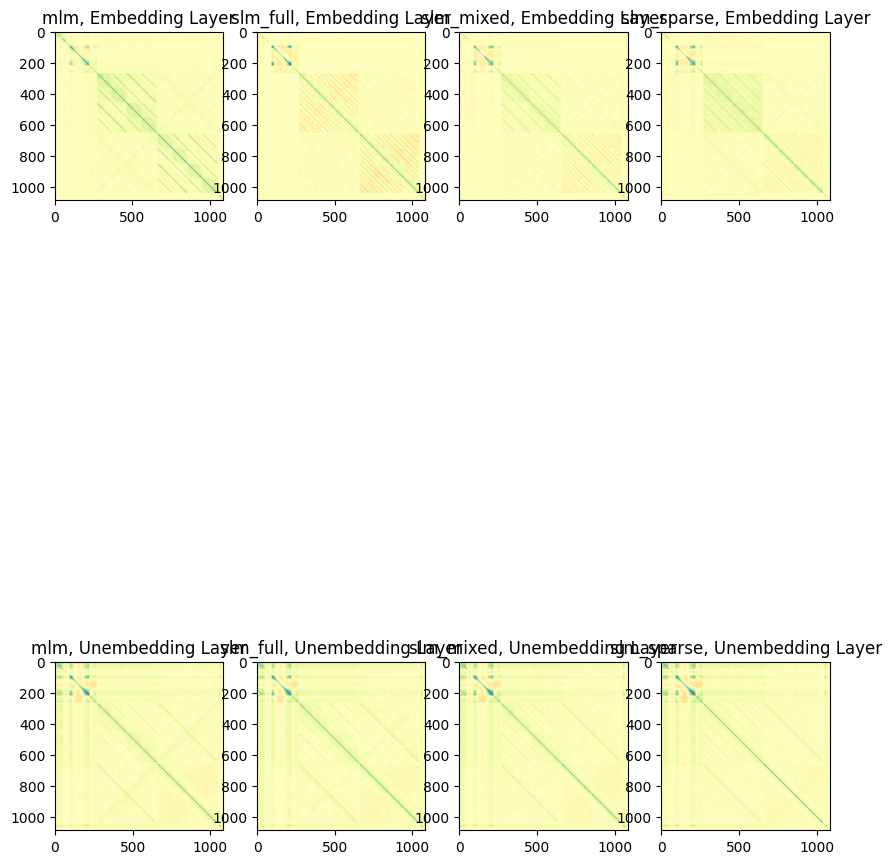

In [23]:
import matplotlib.pyplot as plt


# make 3 by 2 subplot
fig, axs = plt.subplots(2, 4, figsize=(10, 15))

for i, scheme in enumerate(["mlm", "slm_full", "slm_mixed", "slm_sparse"]):
    model = load_model(
        epochs=150,
        model_type=scheme,
        device=DEVICE
    )

    W_e = model.embedding_layer.weight.detach().cpu().T
    W_u = model.unembedding_layer.weight.detach().cpu()

    W_e_norm = W_e / W_e.norm(dim=1, keepdim=True)
    W_u_norm = W_u / W_u.norm(dim=1, keepdim=True)

    # show self similarity of W_e and W_u
    axs[0,i].imshow(W_e_norm @ W_e_norm.T, vmin=-1, vmax=1, cmap="Spectral")
    axs[0,i].set_title(f"{scheme}, Embedding Layer")
    axs[1,i].imshow(W_u_norm @ W_u_norm.T, vmin=-1, vmax=1, cmap="Spectral")

    axs[1,i].set_title(f"{scheme}, Unembedding Layer")

plt.show()


 ## 2. Model Loading and Helper Functions

 We load the model and define helper functions to simplify the generation process.

In [3]:
print(f"Loading model on {DEVICE}...")
# Download checkpoint
model = load_model(
    model_type="slm_mixed",
    epochs=150,
    device=DEVICE
)

if USE_FP16:
    model = model.convert_to_half()

N_EVENTS = model.tokenizer.config["max_notes"]

# Helper to generate tokens from a mask
def generate(
    mask,
    temperature=1.0,
    top_p=1.0,
    top_k=0,
    tokens_per_step=1,
    attribute_temperature=None,
    order="random",
    constraint_cfg=1.0,
):
    out = model.generate(
        mask,
        temperature=temperature,
        tokens_per_step=tokens_per_step,
        top_p=top_p,
        top_k=top_k,
        order=order,
        attribute_temperature=attribute_temperature,
        collapse_duplicates=True,
        constraint_cfg=constraint_cfg,
    )[0].argmax(-1)
    return out

# Helper to convert constraints to music
def generate_from_constraints(e, sampling_params={}):
    print("Generating...")
    mask = model.tokenizer.event_constraints_to_mask(e).to(DEVICE)
    x = generate(
        mask,
        temperature=sampling_params.get("temperature", 1.0),
        top_p=sampling_params.get("top_p", 1.0),
        top_k=sampling_params.get("top_k", 0),
        tokens_per_step=sampling_params.get("tokens_per_step", 1),
        attribute_temperature=sampling_params.get("attribute_temperature", None),
        order=sampling_params.get("order", "random"),
        constraint_cfg=sampling_params.get("constraint_cfg", 1.0),
    )
    x_sm = model.tokenizer.decode(x)
    notes_before = x_sm.note_num()
    x_sm = util.sm_fix_overlap_notes(x_sm)
    notes_after = x_sm.note_num()
    # print(f"Removed {notes_before - notes_after} overlapping notes.")
    return x_sm

# Helper to convert existing ScoreMatrix (sm) to a constraint list
def sm_to_constraint(sm, tag="other"):
    return sm_to_events(sm, tag, tokenizer=model.tokenizer)

# Short alias for creating a new constraint object
ec = lambda: MusicalEventConstraint(model.tokenizer)

print("Ready to generate!")


Loading model on cuda:1...
Loading model from /root/.cache/slm/slm_mixed_150epochs.ckpt...
Ready to generate!


 ## 3. Basic Constrained Generation

 Let's start by creating a simple Rock loop with Drums, Bass, and Guitar.

 We specify the number of notes for each instrument and force them to be active.

In [14]:
def constraint_basic_rock(C, c):
    # add 64 drum notes
    C = [c().intersect({"instrument": {"Drums"}}).force_active() for i in range(64)]
    # add 16 bass notes
    C += [c().intersect({"instrument": {"Bass"}}).force_active() for i in range(16)]
    # add 32 guitar notes
    C += [c().intersect({"instrument": {"Guitar"}}).force_active() for i in range(32)]
    # set tag to "rock"
    C = [c.intersect({"tag": {"rock"}}) for c in C]
    # pad with notes
    C += [c() for _ in range(N_EVENTS - len(C))]
    # set tempo to 140

    C = [c.intersect(ec().tempo_constraint(140)) for c in C]
    return C

print("Generating Basic Rock Loop...")
constraints = constraint_basic_rock([], ec)
sm = generate_from_constraints(constraints, {"temperature": 1.0, "constraint_cfg": 7.0, "tokens_per_step": 1})
# count notes
print(sm.note_num())
preview_sm(sm)


Generating Basic Rock Loop...
Generating...


100%|██████████| 2064/2064 [00:17<00:00, 117.71it/s]

118


In [12]:
print(sm.note_num())

272


 ## 4. Detailed Instrument Control

 We can be much more specific. Here we define a Drum beat with specific kit pieces (Kicks, Snares, Hi-hats) and velocities.

In [13]:
def constraint_detailed_drums(e, ec):
    # add 12 kicks on specific pitch 36
    e = [ec().intersect({"instrument": {"Drums"}, "pitch": {"36 (Drums)"}}).force_active() for i in range(12)]
    # add 4 snares on pitch 38
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": {"38 (Drums)"}}).force_active() for i in range(4)]
    # add 8 low velocity hihats
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": HIHAT_PITCHES}).intersect(ec().velocity_constraint(30)).force_active() for i in range(8)]
    # add 8 high velocity hihats
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": HIHAT_PITCHES}).intersect(ec().velocity_constraint(100)).force_active() for i in range(8)]
    # add 4 toms
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": TOM_PITCHES}).force_active() for i in range(4)]
    # add ten cowbells
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": {"56"}}).force_active() for i in range(10)]
    # set tempo to 130
    e = [ev.intersect(ec().tempo_constraint(130)) for ev in e]

    # pad remaining space
    e += [ec().force_inactive() for _ in range(N_EVENTS - len(e))]
    return e

for cfg in [0.0, 1.0, 3.0, 7.0]:
    print("Generating Detailed Drums...")
    constraints = constraint_detailed_drums([], ec)
    sm = generate_from_constraints(constraints, {"temperature": 1.0, "constraint_cfg": cfg, "tokens_per_step": 1})
    # count notes
    print(f"cfg: {cfg}")
    print(sm.note_num())
    preview_sm(sm)


Generating Detailed Drums...
Generating...


100%|██████████| 234/234 [00:04<00:00, 47.24it/s]


cfg: 0.0
41


Generating Detailed Drums...
Generating...


100%|██████████| 234/234 [00:03<00:00, 64.93it/s]

cfg: 1.0
40


Generating Detailed Drums...
Generating...


100%|██████████| 234/234 [00:04<00:00, 47.54it/s]


cfg: 3.0
46


Generating Detailed Drums...
Generating...


100%|██████████| 234/234 [00:04<00:00, 47.39it/s]


cfg: 7.0
42


 ### 4.1 Disco Beat

 Example of placing instruments on specific beats (Snare on 2 and 4).

In [7]:
def constraint_disco_beat(e, ec):
    e = []
    n_events = ec().get_n_events()
    # add snares on every 2nd and 4th beat (ticks: 24, 72, 120...)
    snare_onset_ticks = [str(t) for t in range(24, 24*16, 48)]
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": {"38 (Drums)"}, "onset/global_tick": {tick}}).intersect(ec().velocity_constraint(120)).force_active() for tick in snare_onset_ticks]
    
    # add hihats (low and high velocity)
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": HIHAT_PITCHES}).intersect(ec().velocity_constraint(30)).force_active() for i in range(20)]
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": HIHAT_PITCHES}).intersect(ec().velocity_constraint(100)).force_active() for i in range(20)]
    
    # add 8 kicks
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": {"36 (Drums)"} }).force_active() for i in range(8)]
    
    # pad
    e += [ec().force_inactive() for _ in range(n_events - len(e))]
    # set tempo to 130
    e = [ev.intersect(ec().tempo_constraint(130)) for ev in e]
    return e

print("Generating Disco Beat...")
constraints = constraint_disco_beat([], ec)
sm = generate_from_constraints(constraints, {"temperature": 1.0})
preview_sm(sm)


Generating Disco Beat...
Generating...


100%|██████████| 264/264 [00:04<00:00, 59.50it/s]


 ## 5. Editing & In-Painting

 SLM can modify existing music. Let's take the previous `sm` (Disco beat) and add a Bass line to it.

In [8]:
# First, we need our source music as a constraint list
source_constraints = sm_to_constraint(sm)

def constraint_add_bass_to_drums(e, ec):
    n_events = ec().get_n_events()
    # Keep only active notes from source
    e = [ev for ev in e if ev.is_active()]

    # Filter out any existing bass (just in case)
    e = [ev for ev in e if "Bass" not in ev["instrument"]]

    # Strategy: Add a bass note for every Kick drum
    bass_e = []
    for ev in e:
        if "Drums" in ev["instrument"] and "36 (Drums)" in ev["pitch"]:
            # Lock bass to same onset as kick
            bass_e.append(ec().intersect({"instrument": {"Bass"}, "onset/global_tick": ev["onset/global_tick"]}).force_active())
    e += bass_e

    # Add some syncopated short bass notes
    syncopated_ticks = {str(t) for t in range(0, 24*16, 6) if t%24!=0}
    e += [ec().intersect({"instrument": {"Bass"}, "duration": {"1/32"}, "onset/global_tick": syncopated_ticks}).force_active() for i in range(10)]
    
    # pad
    e += [ec().force_inactive() for _ in range(n_events - len(e))]
    return e

print("Adding Bass to Disco Beat...")
constraints = constraint_add_bass_to_drums(source_constraints, ec)
sm_with_bass = generate_from_constraints(constraints, {"temperature": 1.0})
preview_sm(sm_with_bass)


Adding Bass to Disco Beat...
Generating...


100%|██████████| 108/108 [00:01<00:00, 60.36it/s]


 ### 5.1 In-Painting (Replacing a section)

 We can replace a specific time range (e.g., the middle 2 bars) while keeping the rest intact.

In [ ]:
def constraint_replace_middle_bars(e, ec, n_events):
    # remove inactive
    e = [ev for ev in e if ev.is_active()]

    # Define the range to replace (Bars 2-4)
    replace_min_ticks = 24 * 4
    replace_max_ticks = 24 * 8
    tick_range = {str(t) for t in range(replace_min_ticks, replace_max_ticks)}

    # Reset events that fall in this range to be "anything" (re-sampled)
    # Or specifically constrain them to be new content. 
    # Here we just check if the event overlaps with the range.
    # Note: Ideally we would mark them as 'unknown' but intersect allows us to re-specify constraints.

    # remove events in the range
    e = [ev for ev in e if not (ev["onset/global_tick"] & tick_range)]
    
    new_tick_range = tick_range.union({"-"})
    # add 50 empty events
    e += [ec().force_inactive() for i in range(100)]
    # add new events with onset in the range or undef 
    e += [ec().intersect({"onset/global_tick": new_tick_range}) for i in range(n_events - len(e))]

    
    return e

print("In-painting middle bars...")
# (Note: This is a simplified in-painting demo; the model will fill the empty slots based on context)
# using sm_with_bass from previous step
constraints = sm_to_constraint(sm_with_bass)
constraints = constraint_replace_middle_bars(constraints, ec, N_EVENTS)
# We actually just want to regenerate part of it. 
# For a strict in-paint, we'd set mask=0 for knowns and mask=1 for unknowns. 
# The constraint API handles this by defining what MUST be there.
# Let's try a specific mutation: Change the bass in the middle

sm_with_bass = generate_from_constraints(constraints, {"topk": 3})
preview_sm(sm_with_bass)

In-painting middle bars...
Generating...


100%|██████████| 1152/1152 [00:06<00:00, 178.89it/s]


 ## 6. Advanced Rhythmic Constraints

 We can enforce specific rhythmic patterns like '4-on-the-floor' or triplets.

In [11]:
def constraint_four_on_floor(e, ec):
    # kicks on every beat
    kick_onset_ticks = {str(t) for t in range(0, 24*16, 24)}
    e = [ec().intersect({"instrument": {"Drums"}, "pitch": {"36 (Drums)"}, "onset/global_tick": kick_onset_ticks}).force_active() for i in range(16)]
    # add 32 hihats
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": HIHAT_PITCHES}).force_active() for i in range(32)]
    # add 16 snares
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": {"38 (Drums)"}}).force_active() for i in range(16)]
    # pad with inactive notes
    e += [ec().force_inactive() for _ in range(N_EVENTS - len(e))]
    return e

print("Generating 4 on the Floor...")
e = constraint_four_on_floor([], ec)
sm = generate_from_constraints(e, {"temperature": 1.0})
preview_sm(sm)

Generating 4 on the Floor...
Generating...


100%|██████████| 416/416 [00:07<00:00, 58.27it/s]


In [12]:
def constraint_drum_triplets(e, ec):
    # one drum note every 12th note (triplet feel)
    e = [
        ec().intersect({"instrument": {"Drums"}, "onset/global_tick": {str(onset_tick)}}).force_active() for onset_tick in range(0, 24*16, 8)
    ]
    # add 32 more drums
    e += [ec().intersect({"instrument": {"Drums"}}).force_active() for i in range(32)]
    
    # add bass on any triplet
    triplet_ticks = {str(t) for t in range(0, 24*16, 8)}
    e += [
        ec().intersect({"instrument": {"Bass"}, "onset/global_tick": triplet_ticks}).force_active() for i in range(12)
    ]
    
    # set tempo
    e = [ev.intersect(ec().tempo_constraint(140)) for ev in e]
    # pad
    e += [ec().force_inactive() for _ in range(N_EVENTS - len(e))]
    return e

print("Generating Triplets...")
e = constraint_drum_triplets([], ec)
sm = generate_from_constraints(e, {"temperature": 1.0})
preview_sm(sm)

Generating Triplets...
Generating...


100%|██████████| 504/504 [00:08<00:00, 58.24it/s]


 ## 7. Pitch & Scale Constraints

 We can restrict instruments to specific scales.

In [13]:
def constraint_scale_pentatonic(e, ec):
    # remove inactive notes if editing, or start fresh
    e = [ev for ev in e if ev.is_active()] if e else []
    
    # Add active notes if starting fresh (example)
    if not e:
         e = [ec().intersect({"instrument": {"Guitar"}}).force_active() for i in range(30)]

    # Apply scale constraint to Bass
    e = [ev.intersect(ec().pitch_in_scale_constraint("G major pentatonic", (20, 50))) 
         if "Guitar" in ev["instrument"] else ev for ev in e]
         
    # pad
    e += [ec().force_inactive() for _ in range(N_EVENTS - len(e))]
    return e

print("Generating Pentatonic Bass...")
# Generating fresh
e = constraint_scale_pentatonic([], ec)
sm = generate_from_constraints(e, {"temperature": 1.0})
preview_sm(sm)

Generating Pentatonic Bass...
Generating...


100%|██████████| 210/210 [00:03<00:00, 61.15it/s]


 ## 8. Fun Extras

 More cowbell?

In [26]:
def constraint_cowbell_heavy(e, ec):
    e = [
        ec().intersect({"instrument": {"Drums"}, "pitch": {"56"}}).force_active() for i in range(10)
    ]
    # add more drums
    e += [ec().intersect({"instrument": {"Drums"}}).force_active() for i in range(40)]
    # pad
    e += [ec().force_inactive() for _ in range(N_EVENTS - len(e))]
    return e

print("Generating Cowbell Loop...")
e = constraint_cowbell_heavy([], ec)
sm = generate_from_constraints(e, {"top_k":5})
preview_sm(sm)

Generating Cowbell Loop...
Generating...


100%|██████████| 340/340 [00:06<00:00, 55.97it/s]
